## Problem Statement

A retail company wants to understand the customer purchase behaviour (specifically, purchase amount) against various products of different categories. They have shared purchase summary of various customers for selected high volume products from last month.
The data set also contains customer demographics (age, gender, marital status, city_type, stay_in_current_city), product details (product_id and product category) and Total purchase_amount from last month.

Now, they want to build a model to predict the purchase amount of customer against various products which will help them to create personalized offer for customers against different products.

## Variable	Definition

In [1]:
# User_ID	User ID
# Product_ID	Product ID
# Gender	Sex of User
# Age	Age in bins
# Occupation	Occupation (Masked)
# City_Category	Category of the City (A,B,C)
# Stay_In_Current_City_Years	Number of years stay in current city
# Marital_Status	Marital Status
# Product_Category_1	Product Category (Masked)
# Product_Category_2	Product may belongs to other category also (Masked)
# Product_Category_3	Product may belongs to other category also (Masked)
# Purchase	Purchase Amount (Target Variable)

## Importing Libraries and Loading data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

In [3]:
data = pd.read_csv('Data/BlackFridaySales.csv')

In [4]:
data.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [5]:
data.shape

(550068, 12)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  object 
 7   Marital_Status              550068 non-null  int64  
 8   Product_Category_1          550068 non-null  int64  
 9   Product_Category_2          376430 non-null  float64
 10  Product_Category_3          166821 non-null  float64
 11  Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


`Age` should be treated as a numerical column

`City_Category` we can convert this to a numerical column and should look at the frequency of each city category.

`Gender` has two values and should be converted to binary values

`Product_Category_2` and `Product_Category_3` have null values

## Checking Null values

In [7]:
data.isnull().sum()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            173638
Product_Category_3            383247
Purchase                           0
dtype: int64

## Null Value in percentage

In [8]:
data.isnull().sum()/data.shape[0]*100

User_ID                        0.000000
Product_ID                     0.000000
Gender                         0.000000
Age                            0.000000
Occupation                     0.000000
City_Category                  0.000000
Stay_In_Current_City_Years     0.000000
Marital_Status                 0.000000
Product_Category_1             0.000000
Product_Category_2            31.566643
Product_Category_3            69.672659
Purchase                       0.000000
dtype: float64

There are 31% null values in the `Product_Category_2` and 69% null values in the `Product_Category_3`

# Unique elements in each attributes

In [9]:
data.nunique()

User_ID                        5891
Product_ID                     3631
Gender                            2
Age                               7
Occupation                       21
City_Category                     3
Stay_In_Current_City_Years        5
Marital_Status                    2
Product_Category_1               20
Product_Category_2               17
Product_Category_3               15
Purchase                      18105
dtype: int64

We can drop `User_ID` and `Product_ID` for model prediction as it has more unique values.

# EDA

## Target Variable Purchase

C:\Users\SAI\AppData\Local\Temp\ipykernel_17304\2016751557.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data["Purchase"],color='r')


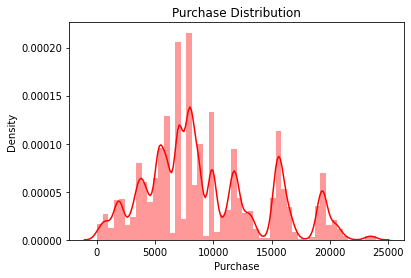

In [10]:
sns.distplot(data["Purchase"],color='r')
plt.title("Purchase Distribution")
plt.show()

We can observe that purchase amount is repeating for many customers.This may be because on Black Friday many are buying discounted products in large numbers and kind of follows a Gaussian Distribution.

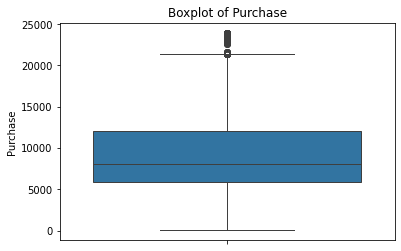

In [11]:
sns.boxplot(data["Purchase"])
plt.title("Boxplot of Purchase")
plt.show()

In [12]:
data["Purchase"].skew()

0.6001400037087128

In [13]:
data["Purchase"].kurtosis()

-0.3383775655851702

In [14]:
data["Purchase"].describe()

count    550068.000000
mean       9263.968713
std        5023.065394
min          12.000000
25%        5823.000000
50%        8047.000000
75%       12054.000000
max       23961.000000
Name: Purchase, dtype: float64

The purchase is right skewed and we can observe multiple peaks in the distribution we can do a log transformation for the purchase.

### Gender

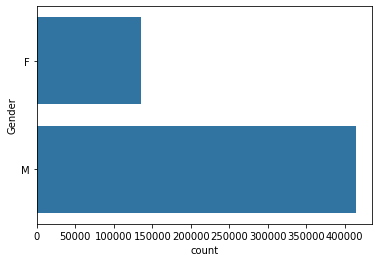

In [15]:
sns.countplot(data['Gender'])
plt.show()

In [16]:
data['Gender'].value_counts(normalize=True)*100

M    75.310507
F    24.689493
Name: Gender, dtype: float64

There are more males than females

In [17]:
data.groupby("Gender").mean()["Purchase"]

Gender
F    8734.565765
M    9437.526040
Name: Purchase, dtype: float64

On average the male gender spends more money on purchase contrary to female, and it is possible to also observe this trend by adding the total value of purchase.

### Marital Status

There are more unmarried people in the dataset who purchase more

In [18]:
data.groupby("Marital_Status").mean()["Purchase"]

Marital_Status
0    9265.907619
1    9261.174574
Name: Purchase, dtype: float64

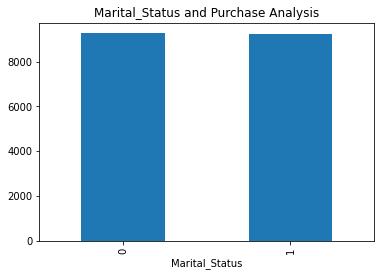

In [19]:
data.groupby("Marital_Status").mean()["Purchase"].plot(kind='bar')
plt.title("Marital_Status and Purchase Analysis")
plt.show()

This is interesting though unmarried people spend more on purchasing, the average purchase amount of married and unmarried people are the same.

### Occupation

Occupation has at least 20 different values. Since we do not known to each occupation each number corresponds, is difficult to make any analysis. Furthermore, it seems we have no alternative but to use since there is no way to reduce this number

In [20]:
occup = pd.DataFrame(data.groupby("Occupation").mean()["Purchase"])
occup

,Purchase
Occupation,
0,9124.428588
1,8953.193270
2,8952.481683
3,9178.593088
4,9213.980251
5,9333.149298
6,9256.535691
7,9425.728223
8,9532.592497


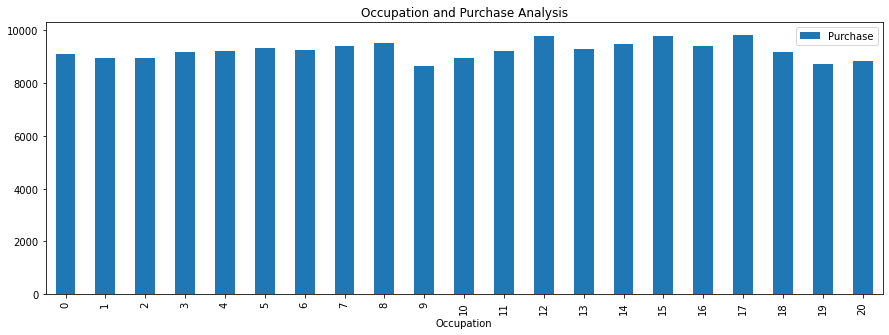

In [21]:
occup.plot(kind='bar',figsize=(15,5))
plt.title("Occupation and Purchase Analysis")
plt.show()

Although there are some occupations which have higher representations, it seems that the amount each user spends on average is more or less the same for all occupations. Of course, in the end, occupations with the highest representations will have the highest amounts of purchases.

### City_Category

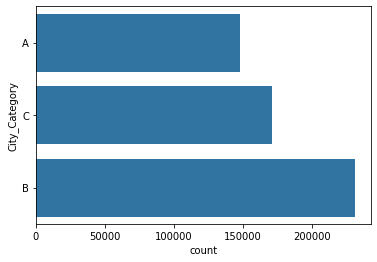

In [22]:
sns.countplot(data['City_Category'])
plt.show()

It is observed that city category B has made the most number of puchases.

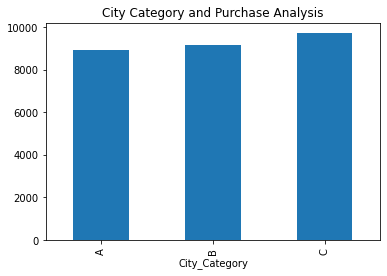

In [23]:
data.groupby("City_Category").mean()["Purchase"].plot(kind='bar')
plt.title("City Category and Purchase Analysis")
plt.show()

However, the city whose buyers spend the most is city type ‘C’.

### Stay_In_Current_City_Years

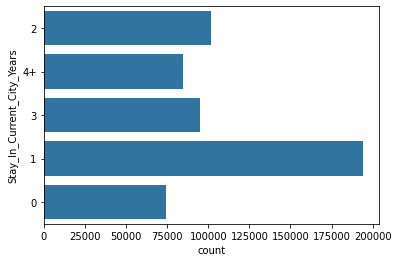

In [24]:
sns.countplot(data['Stay_In_Current_City_Years'])
plt.show()

It looks like the longest someone is living in that city the less prone they are to buy new things. Hence, if someone is new in town and needs a great number of new things for their house that they’ll take advantage of the low prices in Black Friday to purchase all the things needed.

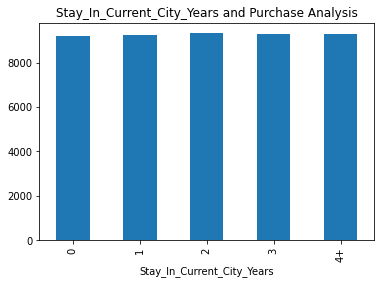

In [25]:
data.groupby("Stay_In_Current_City_Years").mean()["Purchase"].plot(kind='bar')
plt.title("Stay_In_Current_City_Years and Purchase Analysis")
plt.show()

We see the same pattern seen before which show that on average people tend to spend the same amount on purchases regardeless of their group. People who are new in city are responsible for the higher number of purchase, however looking at it individually they tend to spend the same amount independently of how many years the have lived in their current city.

### Age

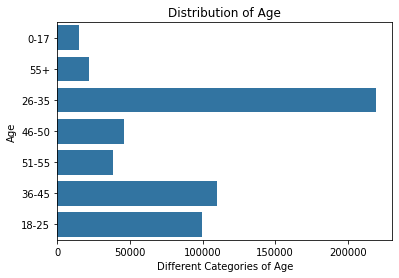

In [26]:
sns.countplot(data['Age'])
plt.title('Distribution of Age')
plt.xlabel('Different Categories of Age')
plt.show()

Age 26-35 Age group makes the most no of purchases in the age group.

<AxesSubplot:xlabel='Age'>

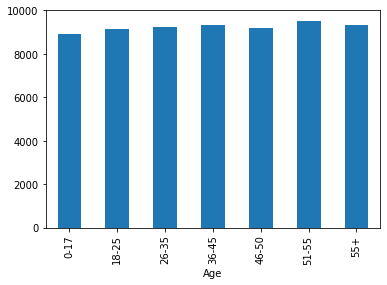

In [27]:
data.groupby("Age").mean()["Purchase"].plot(kind='bar')

Mean puchase rate between the age groups tends to be the same except that the 51-55 age group has a little higher average purchase amount

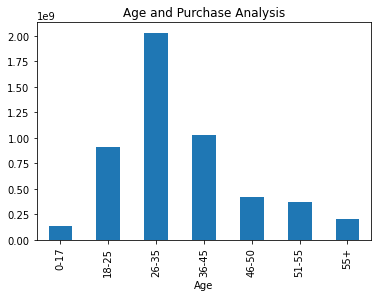

In [28]:
data.groupby("Age").sum()['Purchase'].plot(kind="bar")
plt.title("Age and Purchase Analysis")
plt.show()

Total amount spent in purchase is in accordance with the number of purchases made, distributed by age.

### Product_Category_1

It is clear that `Product_Category_1` numbers 1,5 and 8 stand out. Unfortunately we don't know which product each number represents as it is masked.

If you see the value spent on average for Product_Category_1 you see that although there were more products bought for categories 1,5,8 the average amount spent for those three is not the highest. It is interesting to see other categories appearing with high purchase values despite having low impact on sales number.

The distribution that we saw for this predictor previously appears here. For example, those three products have the highest sum of sales since their were three most sold products.

## HeatMap

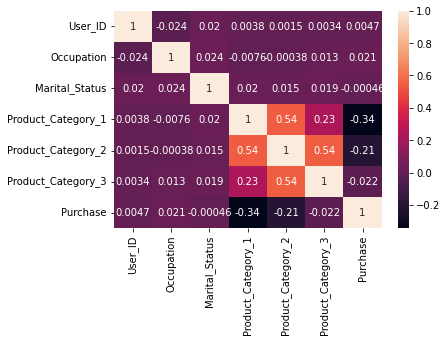

In [29]:
sns.heatmap(data.corr(),annot=True)
plt.show()

There is a some corellation between the product category groups.

In [30]:
data.columns

Index(['User_ID', 'Product_ID', 'Gender', 'Age', 'Occupation', 'City_Category',
       'Stay_In_Current_City_Years', 'Marital_Status', 'Product_Category_1',
       'Product_Category_2', 'Product_Category_3', 'Purchase'],
      dtype='object')

In [31]:
df = data.copy()

In [32]:
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [33]:
#Dummy Variables:
df = pd.get_dummies(df, columns=['Stay_In_Current_City_Years'])

## Encoding the categorical variables

In [34]:
from sklearn.preprocessing import LabelEncoder
lr = LabelEncoder()

In [35]:
df['Gender'] = lr.fit_transform(df['Gender'])

In [36]:
df['Age'] = lr.fit_transform(df['Age'])

In [37]:
df['City_Category'] = lr.fit_transform(df['City_Category'])

In [38]:
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,Stay_In_Current_City_Years_0,Stay_In_Current_City_Years_1,Stay_In_Current_City_Years_2,Stay_In_Current_City_Years_3,Stay_In_Current_City_Years_4+
0,1000001,P00069042,0,0,10,0,0,3,NaN,NaN,8370,0,0,1,0,0
1,1000001,P00248942,0,0,10,0,0,1,6.0,14.0,15200,0,0,1,0,0
2,1000001,P00087842,0,0,10,0,0,12,NaN,NaN,1422,0,0,1,0,0
3,1000001,P00085442,0,0,10,0,0,12,14.0,NaN,1057,0,0,1,0,0
4,1000002,P00285442,1,6,16,2,0,8,NaN,NaN,7969,0,0,0,0,1


In [39]:
df['Product_Category_2'] =df['Product_Category_2'].fillna(0).astype('int64')
df['Product_Category_3'] =df['Product_Category_3'].fillna(0).astype('int64')

In [40]:
df.isnull().sum()

User_ID                          0
Product_ID                       0
Gender                           0
Age                              0
Occupation                       0
City_Category                    0
Marital_Status                   0
Product_Category_1               0
Product_Category_2               0
Product_Category_3               0
Purchase                         0
Stay_In_Current_City_Years_0     0
Stay_In_Current_City_Years_1     0
Stay_In_Current_City_Years_2     0
Stay_In_Current_City_Years_3     0
Stay_In_Current_City_Years_4+    0
dtype: int64

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 16 columns):
 #   Column                         Non-Null Count   Dtype 
---  ------                         --------------   ----- 
 0   User_ID                        550068 non-null  int64 
 1   Product_ID                     550068 non-null  object
 2   Gender                         550068 non-null  int32 
 3   Age                            550068 non-null  int32 
 4   Occupation                     550068 non-null  int64 
 5   City_Category                  550068 non-null  int32 
 6   Marital_Status                 550068 non-null  int64 
 7   Product_Category_1             550068 non-null  int64 
 8   Product_Category_2             550068 non-null  int64 
 9   Product_Category_3             550068 non-null  int64 
 10  Purchase                       550068 non-null  int64 
 11  Stay_In_Current_City_Years_0   550068 non-null  uint8 
 12  Stay_In_Current_City_Years_1   550068 non-nu

## Dropping the irrelevant columns

In [42]:
df = df.drop(["User_ID","Product_ID"],axis=1)

## Splitting data into independent and dependent variables

In [43]:
X = df.drop("Purchase",axis=1)

In [44]:
y=df['Purchase']

In [45]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

## Modeling

In [46]:
def model(m):
    m.fit(X_train, y_train)
    y_pred = m.predict(X_test)
    print(m)
    print("MAE:", mean_absolute_error(y_test, y_pred))
    print("MSE:", mean_squared_error(y_test, y_pred))
    print("R^2:", r2_score(y_test, y_pred))
    print("RMSE:", sqrt(mean_squared_error(y_test, y_pred)))

### Linear Regression

In [47]:
lr = LinearRegression()
model(lr)

LinearRegression()
MAE: 3532.047975712182
MSE: 21397431.75302007
R^2: 0.15194615135968326
RMSE: 4625.735806660392


# DecisionTreeRegressor

In [48]:
regressor = DecisionTreeRegressor(random_state=0)
model(regressor)

DecisionTreeRegressor(random_state=0)
MAE: 2372.0357559134654
MSE: 11300579.466797074
R^2: 0.5521191505924365
RMSE: 3361.633452177241


# Random Forest Regressor

In [51]:
# Takes about 2m 13s on a pc with i3 processor and 8gb ram
RFregressor = RandomForestRegressor(random_state=0) 
model(RFregressor)

RandomForestRegressor(random_state=0)
MAE: 2222.049109204734
MSE: 9310769.87311957
R^2: 0.6309821516972987
RMSE: 3051.35541573242


# XGBoost Regressor

In [50]:
xgb_reg = XGBRegressor(learning_rate=1.0, max_depth=6, min_child_weight=40, seed=0)
model(xgb_reg)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=1.0, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=40, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
MAE: 2141.713511241279
MSE: 8241184.08588845
R^2: 0.6733735168752393
RMSE: 2870.7462594051135


The ML algorithm that perform the best was XGBoost Regressor Model with RMSE = 2871